# ME-NeuralFMU from the Modelica Conference 2021
Tutorial by Johannes Stoljar, Tobias Thummerer

----------

📚📚📚 This tutorial is achieved (so keeping it runnable is low priority). This tutorial further needs heavy refactoring. 📚📚📚

----------

*Last edit: 29.03.2023*

## License

In [1]:
# Copyright (c) 2021 Tobias Thummerer, Lars Mikelsons, Johannes Stoljar
# Licensed under the MIT license. 
# See LICENSE (https://github.com/thummeto/FMIFlux.jl/blob/main/LICENSE) file in the project root for details.

## Motivation
The Julia Package *FMIFlux.jl* is motivated by the application of hybrid modeling. This package enables the user to integrate his simulation model between neural networks (NeuralFMU). For this, the simulation model must be exported as FMU (functional mock-up unit), which corresponds to a widely used standard. The big advantage of hybrid modeling with artificial neural networks is, that the effects that are difficult to model (because they might be unknown) can be easily learned by the neural networks. For this purpose, the NeuralFMU is trained with measurement data containing the not modeled physical effect. The final product is a simulation model including the originally not modeled effects. Another big advantage of the NeuralFMU is that it works with little data, because the FMU already contains the characteristic functionality of the simulation and only the missing effects are added.

NeuralFMUs do not need to be as easy as in this example. Basically a NeuralFMU can combine different ANN topologies that manipulate any FMU-input (system state, system inputs, time) and any FMU-output (system state derivative, system outputs, other system variables). However, for this example a NeuralFMU topology as shown in the following picture is used.

![NeuralFMU.svg](https://github.com/thummeto/FMIFlux.jl/blob/main/docs/src/examples/img/NeuralFMU.svg?raw=true)

*NeuralFMU (ME) from* [[1]](#Source).

## Introduction to the example
In this example, simplified modeling of a one-dimensional spring pendulum (without friction) is compared to a model of the same system that includes a nonlinear friction model. The FMU with the simplified model will be named *simpleFMU* in the following and the model with the friction will be named *realFMU*. At the beginning, the actual state of both simulations is shown, whereby clear deviations can be seen in the graphs. In addition, the initial states are changed for both models and these graphs are also contrasted, and the differences can again be clearly seen. The *realFMU* serves as a reference graph. The *simpleFMU* is then integrated into a NeuralFMU architecture and a training of the entire network is performed. After the training the final state is compared again to the *realFMU*. It can be clearly seen that by using the NeuralFMU, learning of the friction process has taken place.  


## Target group
The example is primarily intended for users who work in the field of first principle and/or hybrid modeling and are further interested in hybrid model building. The example wants to show how simple it is to combine FMUs with machine learning and to illustrate the advantages of this approach.


## Other formats
Besides, this [Jupyter Notebook](https://github.com/thummeto/FMIFlux.jl/blob/examples/examples/src/modelica_conference_2021.ipynb) there is also a [Julia file](https://github.com/thummeto/FMIFlux.jl/blob/examples/examples/src/modelica_conference_2021.jl) with the same name, which contains only the code cells. For the documentation there is a [Markdown file](https://github.com/thummeto/FMIFlux.jl/blob/examples/examples/src/modelica_conference_2021.md) corresponding to the notebook.  


## Getting started

### Installation prerequisites
|     | Description                       | Command                   |   
|:----|:----------------------------------|:--------------------------|
| 1.  | Enter Package Manager via         | ]                         |
| 2.  | Install FMI via                   | add FMI                   | 
| 3.  | Install FMIFlux via               | add FMIFlux               | 
| 4.  | Install FMIZoo via                | add FMIZoo                | 
| 5.  | Install DifferentialEquations via | add DifferentialEquations |  
| 6.  | Install Plots via                 | add Plots                 | 
| 7.  | Install Random via                | add Random                | 

## Code section

To run the example, the previously installed packages must be included. 

In [2]:
# imports
using FMI
using FMIFlux
using FMIFlux.Flux
using FMIZoo
using DifferentialEquations: Tsit5
using Plots

# set seed
import Random
Random.seed!(1234);

After importing the packages, the path to the *Functional Mock-up Units* (FMUs) is set. The exported FMU is a model meeting the *Functional Mock-up Interface* (FMI) Standard. The FMI is a free standard ([fmi-standard.org](http://fmi-standard.org/)) that defines a container and an interface to exchange dynamic models using a combination of XML files, binaries and C code zipped into a single file. 

The object-orientated structure of the *SpringPendulum1D* (*simpleFMU*) can be seen in the following graphic and corresponds to a simple modeling.

![svg](https://github.com/thummeto/FMIFlux.jl/blob/main/docs/src/examples/img/SpringPendulum1D.svg?raw=true)

In contrast, the model *SpringFrictionPendulum1D* (*realFMU*) is somewhat more accurate, because it includes a friction component. 

![svg](https://github.com/thummeto/FMIFlux.jl/blob/main/docs/src/examples/img/SpringFrictionPendulum1D.svg?raw=true)

Next, the start time and end time of the simulation are set. Finally, a step size is specified to store the results of the simulation at these time steps.

In [3]:
tStart = 0.0
tStep = 0.01
tStop = 4.0
tSave = collect(tStart:tStep:tStop)

401-element Vector{Float64}:
 0.0
 0.01
 0.02
 0.03
 0.04
 0.05
 0.06
 0.07
 0.08
 0.09
 0.1
 0.11
 0.12
 ⋮
 3.89
 3.9
 3.91
 3.92
 3.93
 3.94
 3.95
 3.96
 3.97
 3.98
 3.99
 4.0

### RealFMU

In the next lines of code the FMU of the *realFMU* model from *FMIZoo.jl* is loaded and the information about the FMU is shown.  

In [4]:
realFMU = loadFMU("SpringFrictionPendulum1D", "Dymola", "2022x"; type=:ME)
info(realFMU)

#################### Begin information for FMU ####################
	Model name:			SpringFrictionPendulum1D
	FMI-Version:			2.0
	GUID:				{2e178ad3-5e9b-48ec-a7b2-baa5669efc0c}
	Generation tool:		Dymola Version 2022x (64-bit), 2021-10-08
	Generation time:		2022-05-19T06:54:12Z
	Var. naming conv.:		structured
	Event indicators:		24
	Inputs:				0
	Outputs:			0


	States:				2
		33554432 ["mass.s"]
		33554433 ["mass.v", "mass.v_relfric"]
	Parameters:			12
		16777216 ["fricScale"]
		16777217 ["s0"]
		16777218 ["v0"]
		16777219 ["fixed.s0"]
		...
		16777223 ["mass.smin"]
		16777224 ["mass.v_small"]
		16777225 ["mass.L"]
		16777226 ["mass.m"]
		16777227 ["mass.fexp"]
	Supports Co-Simulation:		true
		Model identifier:	SpringFrictionPendulum1D
		Get/Set State:		true
		Serialize State:	true
		Dir. Derivatives:	true
		Var. com. steps:	true
		Input interpol.:	true
		Max order out. der.:	1
	Supports Model-Exchange:	true
		Model identifier:	SpringFrictionPendulum1D
		Get/Set State:		true
		Serialize State:	true
		Dir. Derivatives:	true
##################### End information for FMU #####################


In the following two subsections, the *realFMU* is simulated twice with different initial states to show what effect the choice of initial states has.

#### Default initial states

In the next steps the parameters are defined. The first parameter is the initial position of the mass, which is initialized with $0.5m$, the second parameter is the initial velocity, which is initialized with $0\frac{m}{s}$. In the function `fmiSimulate()` the *realFMU* is simulated, still specifying the start and end time, the parameters and which variables are recorded. After the simulation is finished the result of the *realFMU* can be plotted. This plot also serves as a reference for the other model (*simpleFMU*). The extracted data will still be needed later on.

Simulating ME-FMU ...   0%|█                             |  ETA: N/A

Simulating ME-FMU ... 100%|██████████████████████████████| Time: 0:00:16


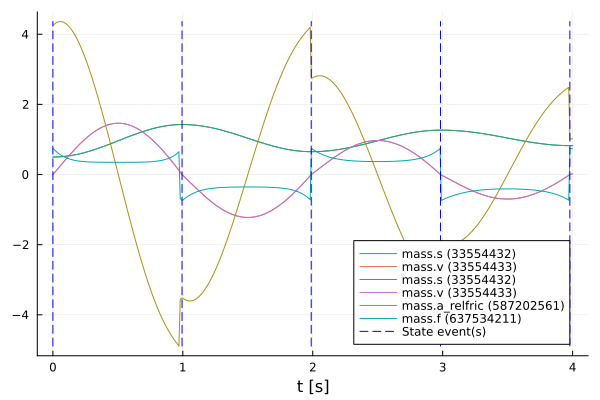

In [5]:
initStates = ["s0", "v0"]
x₀ = [0.5, 0.0]
params = Dict(zip(initStates, x₀))
vrs = ["mass.s", "mass.v", "mass.a", "mass.f"]

realSimData = simulate(realFMU, (tStart, tStop); parameters=params, recordValues=vrs, saveat=tSave)
posReal = getValue(realSimData, "mass.s")
velReal = getValue(realSimData, "mass.v")
plot(realSimData)

#### Define functions

Also, a function to extract the position and velocity from the simulation data is created.

In [6]:
function extractPosVel(simData)
    if simData.states === nothing
        posData = getValue(simData, "mass.s")
        velData = getValue(simData, "mass.v")
    else
        posData = getState(simData, 1; isIndex=true)
        velData = getState(simData, 2; isIndex=true)
    end

    return posData, velData
end

extractPosVel (generic function with 1 method)

#### Modified initial states

In contrast to the previous section, other initial states are selected. The position of the mass is initialized with $1.0m$ and the velocity is initialized with $-1.5\frac{m}{s}$. With the modified initial states the *realFMU* is simulated and a graph is generated.

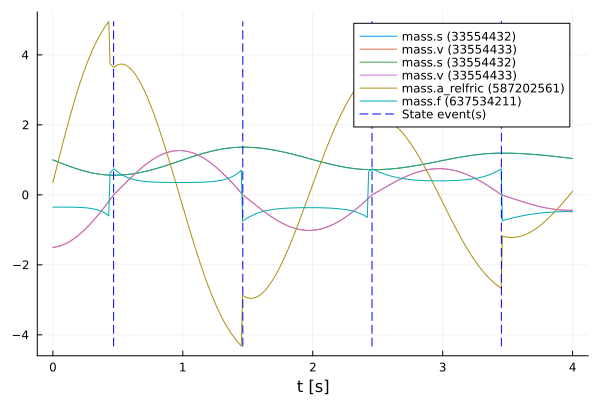

In [7]:
xMod₀ = [1.0, -1.5]
realSimDataMod = simulate(realFMU, (tStart, tStop); parameters=Dict(zip(initStates, xMod₀)), recordValues=vrs, saveat=tSave)
plot(realSimDataMod)

### SimpleFMU

The following lines load the *simpleFMU* from *FMIZoo.jl*. 

In [8]:
simpleFMU = loadFMU("SpringPendulum1D", "Dymola", "2022x"; type=:ME)
info(simpleFMU)

#################### Begin information for FMU ####################
	Model name:			SpringPendulum1D
	FMI-Version:			2.0
	GUID:				{fc15d8c4-758b-48e6-b00e-5bf47b8b14e5}
	Generation tool:		Dymola Version 2022x (64-bit), 2021-10-08
	Generation time:		2022-05-19T06:54:23Z
	Var. naming conv.:		structured
	Event indicators:		0
	Inputs:				0
	Outputs:			0
	States:				2
		33554432 ["mass.s"]
		33554433 ["mass.v"]
	Parameters:			7
		16777216 ["mass_s0"]
		16777217 ["mass_v0"]
		16777218 ["fixed.s0"]
		16777219 ["spring.c"]
		16777220 ["spring.s_rel0"]
		16777221 ["mass.m"]
		16777222 ["mass.L"]
	Supports Co-Simulation:		true
		Model identifier:	SpringPendulum1D
		Get/Set State:		true
		Serialize State:	true
		Dir. Derivatives:	true
		Var. com. steps:	true
		Input interpol.:	true
		Max order out. der.:	1
	Supports Model-Exchange:	true
		Model identifier:	SpringPendulum1D
		Get/Set State:		true
		Serialize State:	true
		Dir. Derivatives:	true
##################### End information for FMU #######

The differences between both systems can be clearly seen from the plots in the subchapters. In the plot for the *realFMU* it can be seen that the oscillation continues to decrease due to the effect of the friction. If you simulate long enough, the oscillation would come to a standstill in a certain time. The oscillation in the *simpleFMU* behaves differently, since the friction was not taken into account here. The oscillation in this model would continue to infinity with the same oscillation amplitude. From this observation the desire of an improvement of this model arises.     


In the following two subsections, the *simpleFMU* is simulated twice with different initial states to show what effect the choice of initial states has.

#### Default initial states

Similar to the simulation of the *realFMU*, the *simpleFMU* is also simulated with the default values for the position and velocity of the mass and then plotted. There is one difference, however, as another state representing a fixed displacement is set. In addition, the last variable is also removed from the variables to be plotted.

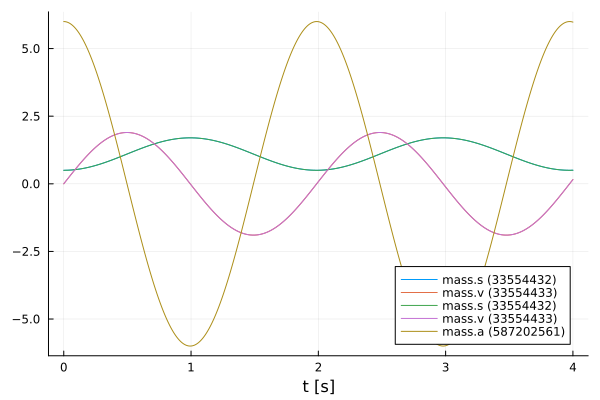

In [9]:
initStates = ["mass_s0", "mass_v0", "fixed.s0"]
displacement = 0.1
xSimple₀ = vcat(x₀, displacement)
vrs = vrs[1:end-1]

simpleSimData = simulate(simpleFMU, (tStart, tStop); parameters=Dict(zip(initStates, xSimple₀)), recordValues=vrs, saveat=tSave)
plot(simpleSimData)

#### Modified initial states

The same values for the initial states are used for this simulation as for the simulation from the *realFMU* with the modified initial states.

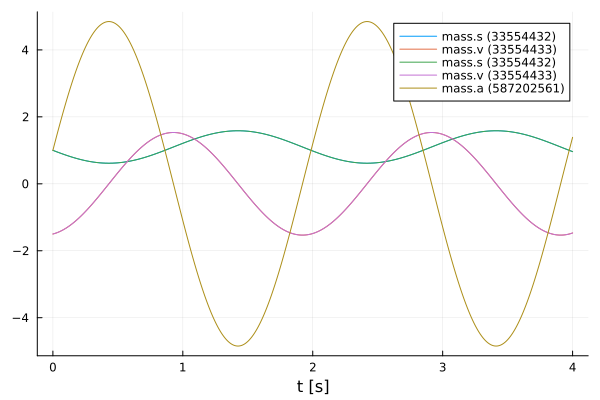

In [10]:
xSimpleMod₀ = vcat(xMod₀, displacement)

simpleSimDataMod = simulate(simpleFMU, (tStart, tStop); parameters=Dict(zip(initStates, xSimpleMod₀)), recordValues=vrs, saveat=tSave)
plot(simpleSimDataMod)

## NeuralFMU

#### Loss function

In order to train our model, a loss function must be implemented. The solver of the NeuralFMU can calculate the gradient of the loss function. The gradient descent is needed to adjust the weights in the neural network so that the sum of the error is reduced and the model becomes more accurate.

The error function in this implementation consists of the mean of the mean squared errors. The first part of the addition is the deviation of the position and the second part is the deviation of the velocity. The mean squared error (mse) for the position consists from the real position of the *realFMU* simulation (posReal) and the position data of the network (posNet). The mean squared error for the velocity consists of the real velocity of the *realFMU* simulation (velReal) and the velocity data of the network (velNet).
$$ e_{loss} = \frac{1}{2} \Bigl[ \frac{1}{n} \sum\limits_{i=0}^n (posReal[i] - posNet[i])^2 + \frac{1}{n} \sum\limits_{i=0}^n (velReal[i] - velNet[i])^2 \Bigr]$$

In [11]:
# loss function for training
function lossSum(p)
    global x₀
    solution = neuralFMU(x₀; p=p)

    posNet, velNet = extractPosVel(solution)

    (FMIFlux.Losses.mse(posReal, posNet) + FMIFlux.Losses.mse(velReal, velNet)) / 2.0
end

lossSum (generic function with 1 method)

#### Callback

To output the loss in certain time intervals, a callback is implemented as a function in the following. Here a counter is incremented, every fiftieth pass the loss function is called and the average error is printed out. Also, the parameters for the velocity in the first layer are kept to a fixed value.

In [12]:
# callback function for training
global counter = 0
function callb(p)
    global counter
    counter += 1

    # freeze first layer parameters (2,4,6) for velocity -> (static) direct feed trough for velocity
    # parameters for position (1,3,5) are learned
    p[1][2] = 0.0
    p[1][4] = 1.0
    p[1][6] = 0.0

    if counter % 50 == 1
        avgLoss = lossSum(p[1])
        @info "  Loss [$counter]: $(round(avgLoss, digits=5))
        Avg displacement in data: $(round(sqrt(avgLoss), digits=5))
        Weight/Scale: $(paramsNet[1][1])   Bias/Offset: $(paramsNet[1][5])"
    end
end

callb (generic function with 1 method)

#### Functions for plotting

In this section some important functions for plotting are defined. The function `generate_figure()` creates a new figure object and sets some attributes.

In [13]:
function generate_figure(title, xLabel, yLabel, xlim=:auto)
    plot(
        title=title, xlabel=xLabel, ylabel=yLabel, linewidth=2,
        xtickfontsize=12, ytickfontsize=12, xguidefontsize=12, yguidefontsize=12,
        legendfontsize=12, legend=:topright, xlim=xlim)
end

generate_figure (generic function with 2 methods)

In the following function, the data of the *realFMU*, *simpleFMU* and *neuralFMU* are summarized and displayed in a graph.

In [14]:
function plot_results(title, xLabel, yLabel, interval, realData, simpleData, neuralData)
    linestyles = [:dot, :solid]
    
    fig = generate_figure(title, xLabel, yLabel)
    plot!(fig, interval, simpleData, label="SimpleFMU", linewidth=2)
    plot!(fig, interval, realData, label="Reference", linewidth=2)
    for i in 1:length(neuralData)
        plot!(fig, neuralData[i][1], neuralData[i][2], label="NeuralFMU ($(i*2500))", 
                    linewidth=2, linestyle=linestyles[i], linecolor=:green)
    end
    display(fig)
end

plot_results (generic function with 1 method)

This is the superordinate function, which at the beginning extracts the position and velocity from the simulation data (`realSimData`, `realSimDataMod`, `simpleSimData`,..., `solutionAfterMod`). Four graphs are then generated, each comparing the corresponding data from the *realFMU*, *simpleFMU*, and *neuralFMU*. The comparison is made with the simulation data from the simulation with the default and modified initial states. According to the data, the designation of the title and the naming of the axes is adapted.

In [15]:
function plot_all_results(realSimData, realSimDataMod, simpleSimData, 
        simpleSimDataMod, solutionAfter, solutionAfterMod)    
    # collect all data
    posReal, velReal = extractPosVel(realSimData)
    posRealMod, velRealMod = extractPosVel(realSimDataMod)
    posSimple, velSimple = extractPosVel(simpleSimData)
    posSimpleMod, velSimpleMod = extractPosVel(simpleSimDataMod)
    
    run = length(solutionAfter)
    
    posNeural, velNeural = [], []
    posNeuralMod, velNeuralMod = [], []
    for i in 1:run
        dataNeural = extractPosVel(solutionAfter[i])
        time = getTime(solutionAfter[i])

        push!(posNeural, (time, dataNeural[1]))
        push!(velNeural, (time, dataNeural[2]))
        
        dataNeuralMod = extractPosVel(solutionAfterMod[i])
        time = getTime(solutionAfterMod[i])
        push!(posNeuralMod, (time, dataNeuralMod[1]))
        push!(velNeuralMod, (time, dataNeuralMod[2]))
    end
         
    # plot results s (default initial states)
    xLabel="t [s]"
    yLabel="mass position [m]"
    title = "Default: Mass position after Run: $(run)"
    plot_results(title, xLabel, yLabel, tSave, posReal, posSimple, posNeural)

    # plot results s (modified initial states)
    title = "Modified: Mass position after Run: $(run)"
    plot_results(title, xLabel, yLabel, tSave, posRealMod, posSimpleMod, posNeuralMod)

    # plot results v (default initial states)
    yLabel="mass velocity [m/s]"
    title = "Default: Mass velocity after Run: $(run)"
    plot_results(title, xLabel, yLabel, tSave, velReal, velSimple, velNeural)

    # plot results v (modified initial states)    
    title = "Modified: Mass velocity after Run: $(run)"
    plot_results(title, xLabel, yLabel, tSave, velRealMod, velSimpleMod, velNeuralMod)
end

plot_all_results (generic function with 1 method)

The function `plot_friction_model()` compares the friction model of the *realFMU*, *simpleFMU* and *neuralFMU*. For this, the velocity and force from the simulation data of the *realFMU* is needed. The force data is calculated with the extracted last layer of the *neuralFMU* to the real velocity in line 9 by iterating over the vector `velReal`. In the next rows, the velocity and force data (if available) for each of the three FMUs are combined into a matrix. The first row of the matrix corresponds to the later x-axis and here the velocity is plotted. The second row corresponds to the y-axis and here the force is plotted. This matrix is sorted and plotted by the first entries (velocity) with the function `sortperm()`. The graph with at least three graphs is plotted in line 33. As output this function has the forces of the *neuralFMU*.

In [16]:
function plot_friction_model!(realSimData, netBottom, forces)    
    linestyles = [:dot, :solid]
    
    velReal = getValue(realSimData, "mass.v")
    forceReal = getValue(realSimData, "mass.f")

    push!(forces, zeros(length(velReal)))
    for i in 1:length(velReal)
        forces[end][i] = -netBottom([velReal[i], 0.0])[2]
    end

    run = length(forces) 
    
    fig = generate_figure("Friction model $(run)", "v [m/s]", "friction force [N]", (-1.25, 1.25))

    fricSimple = hcat(velReal, zeros(length(velReal)))
    fricSimple[sortperm(fricSimple[:, 1]), :]
    Plots.plot!(fig, fricSimple[:,1], fricSimple[:,2], label="SimpleFMU", linewidth=2)

    fricReal = hcat(velReal, forceReal)
    fricReal[sortperm(fricReal[:, 1]), :]
    plot!(fig, fricReal[:,1], fricReal[:,2], label="reference", linewidth=2)

    for i in 1:run
        fricNeural = hcat(velReal, forces[i])
        fricNeural[sortperm(fricNeural[:, 1]), :]
        plot!(fig, fricNeural[:,1], fricNeural[:,2], label="NeuralFMU ($(i*2500))", 
                    linewidth=2, linestyle=linestyles[i], linecolor=:green)
        @info "Friction model $i mse: $(FMIFlux.Losses.mse(fricNeural[:,2], fricReal[:,2]))"
    end
    flush(stderr)

    display(fig)
    
    return nothing
end

plot_friction_model! (generic function with 1 method)

The following function is used to display the different displacement modells of the *realFMU*, *simpleFMU* and *neuralFMU*. The displacement of the *realFMU* and *simpleFMU* is very trivial and is only a constant. The position data of the *realFMU* is needed to calculate the displacement. The displacement for the *neuralFMU* is calculated using the first extracted layer of the neural network, subtracting the real position and the displacement of the *simpleFMU*. Also in this function, the graphs of the three FMUs are compared in a plot.

In [17]:
function plot_displacement_model!(realSimData, netTop, displacements, tSave, displacement)
    linestyles = [:dot, :solid]
    
    posReal = getValue(realSimData, "mass.s")
    
    push!(displacements, zeros(length(posReal)))
    for i in 1:length(posReal)
        displacements[end][i] = netTop([posReal[i], 0.0])[1] - posReal[i] - displacement
    end

    run = length(displacements)
    fig = generate_figure("Displacement model $(run)", "t [s]", "displacement [m]")
    plot!(fig, [tSave[1], tSave[end]], [displacement, displacement], label="simpleFMU", linewidth=2)
    plot!(fig, [tSave[1], tSave[end]], [0.0, 0.0], label="reference", linewidth=2)
    for i in 1:run
        plot!(fig, tSave, displacements[i], label="NeuralFMU ($(i*2500))", 
                    linewidth=2, linestyle=linestyles[i], linecolor=:green)
    end

    display(fig)
    
    return nothing
end

plot_displacement_model! (generic function with 1 method)

#### Structure of the NeuralFMU

In the following, the topology of the NeuralFMU is constructed. It consists of a dense layer that has exactly as many inputs and outputs as the model has states `numStates` (and therefore state derivatives). It also sets the initial weights and offsets for the first dense layer, as well as the activation function, which consists of the identity. An input layer follows, which then leads into the *simpleFMU* model. The ME-FMU computes the state derivatives for a given system state. Following the *simpleFMU* is a dense layer that has `numStates` states. The output of this layer consists of 8 output nodes and a *identity* activation function. The next layer has 8 input and output nodes with a *tanh* activation function. The last layer is again a dense layer with 8 input nodes and the number of states as outputs. Here, it is important that no *tanh*-activation function follows, because otherwise the pendulums state values would be limited to the interval $[-1;1]$.

In [18]:
# NeuralFMU setup
numStates = getNumberOfStates(simpleFMU)

# diagonal matrix 
initW = zeros(numStates, numStates)
for i in 1:numStates
    initW[i,i] = 1
end

net = Chain(Dense(numStates, numStates,  identity),
            x -> simpleFMU(x=x, dx_refs=:all),
            Dense(numStates, 8, identity),
            Dense(8, 8, tanh),
            Dense(8, numStates))

Chain(
  Dense(2 => 2),                        # 6 parameters
  var"#1#2"(),
  Dense(2 => 8),                        # 24 parameters
  Dense(8 => 8, tanh),                  # 72 parameters
  Dense(8 => 2),                        # 18 parameters
)                   # Total: 8 arrays, 120 parameters, 992 bytes.

#### Definition of the NeuralFMU

The instantiation of the ME-NeuralFMU is done as a one-liner. The FMU (*simpleFMU*), the structure of the network `net`, start `tStart` and end time `tStop`, the numerical solver `Tsit5()` and the time steps `tSave` for saving are specified.

In [19]:
neuralFMU = ME_NeuralFMU(simpleFMU, net, (tStart, tStop), Tsit5(); saveat=tSave);

#### Plot before training

Here the state trajectory of the *simpleFMU* is recorded. Doesn't really look like a pendulum yet, but the system is random initialized by default. In the plots later on, the effect of learning can be seen.

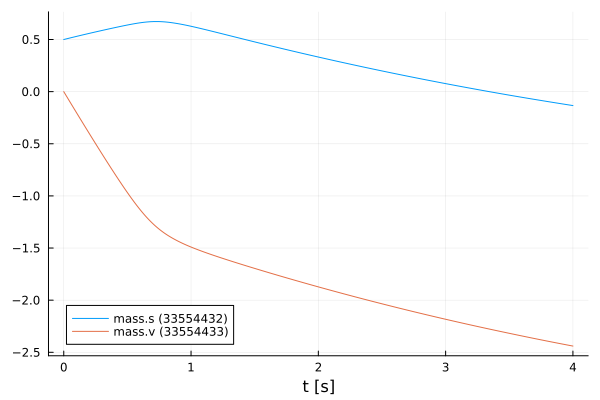

In [20]:
solutionBefore = neuralFMU(x₀)
plot(solutionBefore)

#### Training of the NeuralFMU

For the training of the NeuralFMU the parameters are extracted. All parameters of the first layer are set to the absolute value.

In [21]:
# train
paramsNet = FMIFlux.params(neuralFMU)

for i in 1:length(paramsNet[1])
    if paramsNet[1][i] < 0.0 
        paramsNet[1][i] = -paramsNet[1][i]
    end
end

The well-known Adam optimizer for minimizing the gradient descent is used as further passing parameters. Additionally, the previously defined loss and callback function as well as a one for the number of epochs are passed. Only one epoch is trained so that the NeuralFMU is precompiled.

In [22]:
optim = Adam()
FMIFlux.train!(lossSum, neuralFMU, Iterators.repeated((), 1), optim; cb=()->callb(paramsNet)) 

┌ Info:   Loss [1]: 0.63854
│         Avg displacement in data: 0.79909
└         Weight/Scale: 0.5550727972914904   Bias/Offset: 0.0009999999899930306


Some vectors for collecting data are initialized and the number of runs, epochs and iterations are set.

In [23]:
solutionAfter = []
solutionAfterMod = []
forces = []
displacements = []

numRuns = 2
numEpochs= 5
numIterations = 500;

#### Training loop

The code section shown here represents the training loop. The loop is structured so that it has `numRuns` runs, where each run has `numEpochs` epochs, and the training is performed at each epoch with `numIterations` iterations. In lines 9 and 10, the data for the *neuralFMU* for the default and modified initial states are appended to the corresponding vectors. The plots for the opposition of position and velocity is done in line 13 by calling the function `plot_all_results`. In the following lines the last layers are extracted from the *neuralFMU* and formed into an independent network `netBottom`. The parameters for the `netBottom` network come from the original architecture and are shared. In line 20, the new network is used to represent the friction model in a graph. An analogous construction of the next part of the training loop, where here the first layer is taken from the *neuralFMU* and converted to its own network `netTop`. This network is used to record the displacement model. The different graphs are generated for each run and can thus be compared. 

[ Info: Run: 1/2  Epoch: 1/5


┌ Info:   Loss [51]: 0.45217
│         Avg displacement in data: 0.67244
└         Weight/Scale: 0.6029313727409417   Bias/Offset: 0.04838982792298539


┌ Info:   Loss [101]: 0.38871
│         Avg displacement in data: 0.62346
└         Weight/Scale: 0.6410513958850733   Bias/Offset: 0.08756850912808462


┌ Info:   Loss [151]: 0.35475
│         Avg displacement in data: 0.59561
└         Weight/Scale: 0.6706310161016641   Bias/Offset: 0.1194583853018859


┌ Info:   Loss [201]: 0.3351
│         Avg displacement in data: 0.57887
└         Weight/Scale: 0.6941713002366973   Bias/Offset: 0.14552377657493937


┌ Info:   Loss [251]: 0.323
│         Avg displacement in data: 0.56834
└         Weight/Scale: 0.7130400884743852   Bias/Offset: 0.1666381199317015


┌ Info:   Loss [301]: 0.31495
│         Avg displacement in data: 0.5612
└         Weight/Scale: 0.7281354038982668   Bias/Offset: 0.18339234053778794


┌ Info:   Loss [351]: 0.30855
│         Avg displacement in data: 0.55547
└         Weight/Scale: 0.7400848576770966   Bias/Offset: 0.19618836771630763


┌ Info:   Loss [401]: 0.29993
│         Avg displacement in data: 0.54766
└         Weight/Scale: 0.7494160703081445   Bias/Offset: 0.20518935235560415


┌ Info:   Loss [451]: 0.283
│         Avg displacement in data: 0.53198
└         Weight/Scale: 0.7569472375897621   Bias/Offset: 0.21018863953659989


┌ Info:   Loss [501]: 0.2292
│         Avg displacement in data: 0.47875
└         Weight/Scale: 0.763209453810433   Bias/Offset: 0.20972727851143513
[ Info: Run: 1/2  Epoch: 2/5


┌ Info:   Loss [551]: 0.15297
│         Avg displacement in data: 0.39111
└         Weight/Scale: 0.7716294020933754   Bias/Offset: 0.21500804696457382


┌ Info:   Loss [601]: 0.03121
│         Avg displacement in data: 0.17666
└         Weight/Scale: 0.787650243323763   Bias/Offset: 0.23930263953061687


┌ Info:   Loss [651]: 0.02377
│         Avg displacement in data: 0.15419
└         Weight/Scale: 0.7828851053398479   Bias/Offset: 0.23011146927498835


┌ Info:   Loss [701]: 0.02011
│         Avg displacement in data: 0.14183
└         Weight/Scale: 0.7798450590951862   Bias/Offset: 0.22482265492637088


┌ Info:   Loss [751]: 0.01798
│         Avg displacement in data: 0.13409
└         Weight/Scale: 0.7772658793823928   Bias/Offset: 0.2208114990088981


┌ Info:   Loss [801]: 0.01718
│         Avg displacement in data: 0.13105
└         Weight/Scale: 0.7750933517617076   Bias/Offset: 0.21795103458471568


┌ Info:   Loss [851]: 0.01598
│         Avg displacement in data: 0.12642
└         Weight/Scale: 0.7730325041518178   Bias/Offset: 0.21568935476199486


┌ Info:   Loss [901]: 0.01554
│         Avg displacement in data: 0.12465
└         Weight/Scale: 0.7715978702919699   Bias/Offset: 0.21431545688955456


┌ Info:   Loss [951]: 0.01526
│         Avg displacement in data: 0.12355
└         Weight/Scale: 0.7702666841258349   Bias/Offset: 0.21303130050779182


┌ Info:   Loss [1001]: 0.01483
│         Avg displacement in data: 0.12177
└         Weight/Scale: 0.7684255238986611   Bias/Offset: 0.21121321082939043
[ Info: Run: 1/2  Epoch: 3/5


┌ Info:   Loss [1051]: 0.0142
│         Avg displacement in data: 0.11915
└         Weight/Scale: 0.7668961621637944   Bias/Offset: 0.2100001457035587


┌ Info:   Loss [1101]: 0.01399
│         Avg displacement in data: 0.11828
└         Weight/Scale: 0.7653014470322085   Bias/Offset: 0.20898426677677534


┌ Info:   Loss [1151]: 0.01359
│         Avg displacement in data: 0.11658
└         Weight/Scale: 0.7636902062254607   Bias/Offset: 0.2078315731260719


┌ Info:   Loss [1201]: 0.01368
│         Avg displacement in data: 0.11695
└         Weight/Scale: 0.7618945596000443   Bias/Offset: 0.2062826683387349


┌ Info:   Loss [1251]: 0.01288
│         Avg displacement in data: 0.11348
└         Weight/Scale: 0.7602320129169557   Bias/Offset: 0.20484587888704264


┌ Info:   Loss [1301]: 0.0128
│         Avg displacement in data: 0.11312
└         Weight/Scale: 0.7584852446811282   Bias/Offset: 0.20333738756961667


┌ Info:   Loss [1351]: 0.01233
│         Avg displacement in data: 0.11104
└         Weight/Scale: 0.756805477769466   Bias/Offset: 0.20193445972145055


┌ Info:   Loss [1401]: 0.01212
│         Avg displacement in data: 0.11008
└         Weight/Scale: 0.7551823522843474   Bias/Offset: 0.2008023490657473


┌ Info:   Loss [1451]: 0.01184
│         Avg displacement in data: 0.10881
└         Weight/Scale: 0.7535919652320717   Bias/Offset: 0.19983767373972636


┌ Info:   Loss [1501]: 0.01176
│         Avg displacement in data: 0.10843
└         Weight/Scale: 0.7521206937747862   Bias/Offset: 0.1989686681528405


[ Info: Run: 1/2  Epoch: 4/5
┌ Info:   Loss [1551]: 0.01135
│         Avg displacement in data: 0.10653
└         Weight/Scale: 0.7506097264801087   Bias/Offset: 0.19789621918008185


┌ Info:   Loss [1601]: 0.01147
│         Avg displacement in data: 0.10708
└         Weight/Scale: 0.7490762274238789   Bias/Offset: 0.19679825504096937


┌ Info:   Loss [1651]: 0.01135
│         Avg displacement in data: 0.10655
└         Weight/Scale: 0.7479131226007704   Bias/Offset: 0.19583276534128222


┌ Info:   Loss [1701]: 0.01049
│         Avg displacement in data: 0.10241
└         Weight/Scale: 0.7464845792271897   Bias/Offset: 0.19458437809896817


┌ Info:   Loss [1751]: 0.01043
│         Avg displacement in data: 0.10214
└         Weight/Scale: 0.7450419476954268   Bias/Offset: 0.19313117283238865


┌ Info:   Loss [1801]: 0.01035
│         Avg displacement in data: 0.10175
└         Weight/Scale: 0.7434982725757668   Bias/Offset: 0.19176644882018015


┌ Info:   Loss [1851]: 0.00998
│         Avg displacement in data: 0.09991
└         Weight/Scale: 0.7424112848046222   Bias/Offset: 0.19088389470922154


┌ Info:   Loss [1901]: 0.01006
│         Avg displacement in data: 0.10029
└         Weight/Scale: 0.7408925985826832   Bias/Offset: 0.18942704817573972


┌ Info:   Loss [1951]: 0.00939
│         Avg displacement in data: 0.09692
└         Weight/Scale: 0.7394017503105694   Bias/Offset: 0.1880006742329454


┌ Info:   Loss [2001]: 0.00899
│         Avg displacement in data: 0.09481
└         Weight/Scale: 0.7379782021500545   Bias/Offset: 0.18645999496249335


[ Info: Run: 1/2  Epoch: 5/5
┌ Info:   Loss [2051]: 0.00847
│         Avg displacement in data: 0.09201
└         Weight/Scale: 0.7365607177262747   Bias/Offset: 0.18511411682205303


┌ Info:   Loss [2101]: 0.00776
│         Avg displacement in data: 0.08812
└         Weight/Scale: 0.7356629818063877   Bias/Offset: 0.18398681068840644


┌ Info:   Loss [2151]: 0.00682
│         Avg displacement in data: 0.08258
└         Weight/Scale: 0.7351706437693412   Bias/Offset: 0.1829903640856176


┌ Info:   Loss [2201]: 0.00586
│         Avg displacement in data: 0.07655
└         Weight/Scale: 0.7353706389879586   Bias/Offset: 0.18234241887698246


┌ Info:   Loss [2251]: 0.00489
│         Avg displacement in data: 0.06991
└         Weight/Scale: 0.7367753264087095   Bias/Offset: 0.18275195104096703


┌ Info:   Loss [2301]: 0.00412
│         Avg displacement in data: 0.06419
└         Weight/Scale: 0.7389656946343818   Bias/Offset: 0.18426555560023747


┌ Info:   Loss [2351]: 0.00373
│         Avg displacement in data: 0.06108
└         Weight/Scale: 0.7408731376166495   Bias/Offset: 0.18601965833172573


┌ Info:   Loss [2401]: 0.00345
│         Avg displacement in data: 0.0587
└         Weight/Scale: 0.7421882203300983   Bias/Offset: 0.187523764283474


┌ Info:   Loss [2451]: 0.00315
│         Avg displacement in data: 0.05611
└         Weight/Scale: 0.7431584207431337   Bias/Offset: 0.18889845772789696


┌ Info:   Loss [2501]: 0.00291
│         Avg displacement in data: 0.05398
└         Weight/Scale: 0.7438872351944437   Bias/Offset: 0.19014429963747764


 98.641173 seconds (1.32 G allocations: 59.333 GiB, 8.70% gc time, 0.09% compilation time)


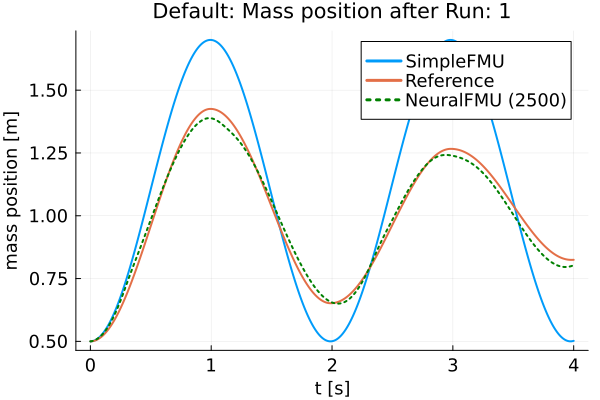

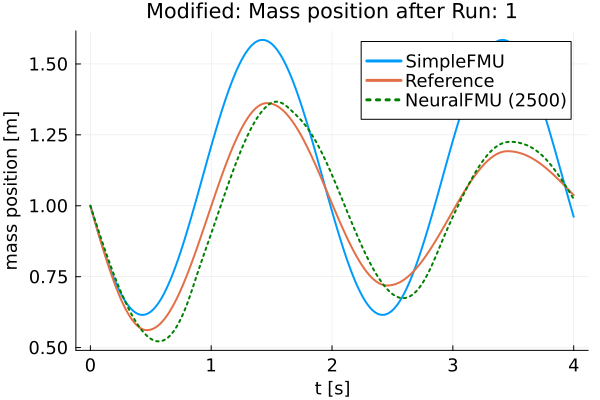

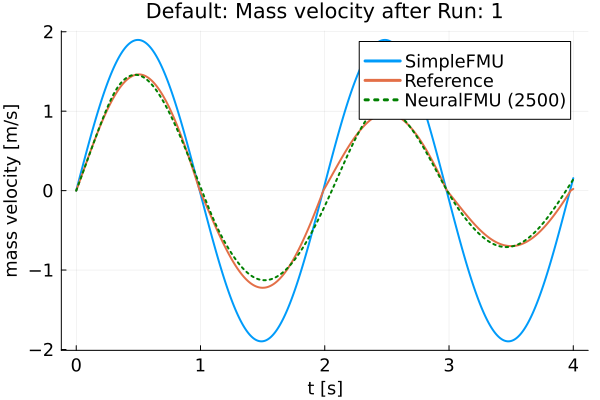

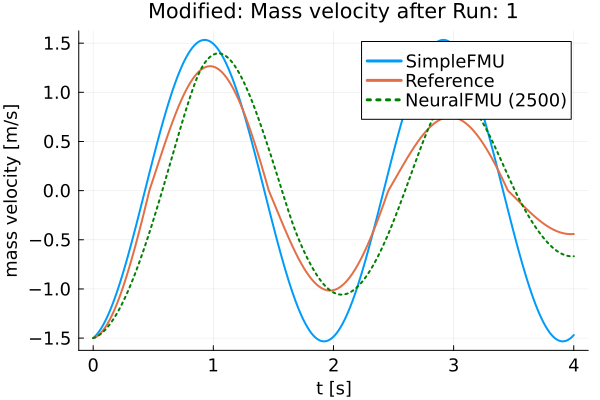

[ Info: Friction model 1 mse: 16.30873694544497


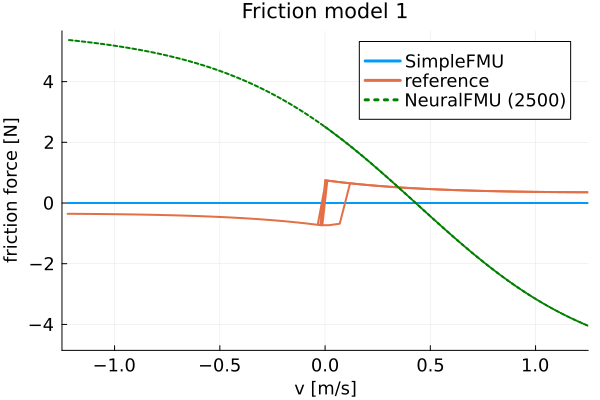

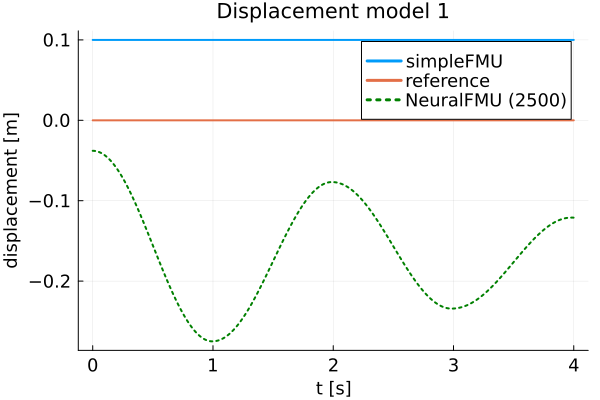

[ Info: Run: 2/2  Epoch: 1/5
┌ Info:   Loss [2551]: 0.00286
│         Avg displacement in data: 0.05344
└         Weight/Scale: 0.7440471016905091   Bias/Offset: 0.19051256263468003


┌ Info:   Loss [2601]: 0.00281
│         Avg displacement in data: 0.05304
└         Weight/Scale: 0.7441520323167196   Bias/Offset: 0.19100931281544642


┌ Info:   Loss [2651]: 0.00278
│         Avg displacement in data: 0.05269
└         Weight/Scale: 0.7441802974794633   Bias/Offset: 0.1915679209490836


┌ Info:   Loss [2701]: 0.00262
│         Avg displacement in data: 0.0512
└         Weight/Scale: 0.7441452629247564   Bias/Offset: 0.19217317966556552


┌ Info:   Loss [2751]: 0.0026
│         Avg displacement in data: 0.05095
└         Weight/Scale: 0.7440690291135971   Bias/Offset: 0.19282255883094956


┌ Info:   Loss [2801]: 0.00254
│         Avg displacement in data: 0.05035
└         Weight/Scale: 0.7439840708085347   Bias/Offset: 0.19352858466455405


┌ Info:   Loss [2851]: 0.00241
│         Avg displacement in data: 0.04909
└         Weight/Scale: 0.7439098114024602   Bias/Offset: 0.19429651151628144


┌ Info:   Loss [2901]: 0.00232
│         Avg displacement in data: 0.04817
└         Weight/Scale: 0.743861525347209   Bias/Offset: 0.19513204194545583


┌ Info:   Loss [2951]: 0.00225
│         Avg displacement in data: 0.04747
└         Weight/Scale: 0.7438426796785472   Bias/Offset: 0.1960372112400526


┌ Info:   Loss [3001]: 0.00218
│         Avg displacement in data: 0.04673
└         Weight/Scale: 0.7438315491972639   Bias/Offset: 0.19698127821198744
[ Info: Run: 2/2  Epoch: 2/5


┌ Info:   Loss [3051]: 0.0021
│         Avg displacement in data: 0.04584
└         Weight/Scale: 0.7438199538351697   Bias/Offset: 0.19793962190968858


┌ Info:   Loss [3101]: 0.00203
│         Avg displacement in data: 0.04504
└         Weight/Scale: 0.743812387659078   Bias/Offset: 0.1989016530011808


┌ Info:   Loss [3151]: 0.00195
│         Avg displacement in data: 0.04421
└         Weight/Scale: 0.7438159421376663   Bias/Offset: 0.19986438458439829


┌ Info:   Loss [3201]: 0.00186
│         Avg displacement in data: 0.04317
└         Weight/Scale: 0.7438336302851711   Bias/Offset: 0.2008270242430251


┌ Info:   Loss [3251]: 0.00175
│         Avg displacement in data: 0.04188
└         Weight/Scale: 0.743866110866574   Bias/Offset: 0.20179263065385966


┌ Info:   Loss [3301]: 0.00168
│         Avg displacement in data: 0.04102
└         Weight/Scale: 0.7439138992407596   Bias/Offset: 0.20276479630834549


┌ Info:   Loss [3351]: 0.00159
│         Avg displacement in data: 0.03991
└         Weight/Scale: 0.7439743154761158   Bias/Offset: 0.20374272681713113


┌ Info:   Loss [3401]: 0.00149
│         Avg displacement in data: 0.03857
└         Weight/Scale: 0.7440415361146039   Bias/Offset: 0.20472150692564062


┌ Info:   Loss [3451]: 0.00174
│         Avg displacement in data: 0.04167
└         Weight/Scale: 0.7441084625478972   Bias/Offset: 0.2056934574533521


┌ Info:   Loss [3501]: 0.00136
│         Avg displacement in data: 0.03688
└         Weight/Scale: 0.7441695114493807   Bias/Offset: 0.20665220126400813
[ Info: Run: 2/2  Epoch: 3/5


┌ Info:   Loss [3551]: 0.0013
│         Avg displacement in data: 0.03608
└         Weight/Scale: 0.7442249966603137   Bias/Offset: 0.20760125403750768


┌ Info:   Loss [3601]: 0.00124
│         Avg displacement in data: 0.03523
└         Weight/Scale: 0.7442572308006917   Bias/Offset: 0.20852557164606914


┌ Info:   Loss [3651]: 0.00121
│         Avg displacement in data: 0.03479
└         Weight/Scale: 0.7442878448172773   Bias/Offset: 0.2094553315039913


┌ Info:   Loss [3701]: 0.00114
│         Avg displacement in data: 0.03371
└         Weight/Scale: 0.7443301832225057   Bias/Offset: 0.21042460022082887


┌ Info:   Loss [3751]: 0.00105
│         Avg displacement in data: 0.03236
└         Weight/Scale: 0.7443831241556889   Bias/Offset: 0.21145248481423115


┌ Info:   Loss [3801]: 0.001
│         Avg displacement in data: 0.03168
└         Weight/Scale: 0.7444058764263503   Bias/Offset: 0.21250696589685578


┌ Info:   Loss [3851]: 0.00099
│         Avg displacement in data: 0.03139
└         Weight/Scale: 0.744435715605685   Bias/Offset: 0.21360601813775762


┌ Info:   Loss [3901]: 0.00092
│         Avg displacement in data: 0.03033
└         Weight/Scale: 0.7442496932936764   Bias/Offset: 0.21453399349411345


┌ Info:   Loss [3951]: 0.00088
│         Avg displacement in data: 0.02972
└         Weight/Scale: 0.7439698954615857   Bias/Offset: 0.21527045751233106


┌ Info:   Loss [4001]: 0.00085
│         Avg displacement in data: 0.02911
└         Weight/Scale: 0.7436711003148889   Bias/Offset: 0.2158836769905478
[ Info: Run: 2/2  Epoch: 4/5


┌ Info:   Loss [4051]: 0.00081
│         Avg displacement in data: 0.02852
└         Weight/Scale: 0.7433670891138677   Bias/Offset: 0.21640001472227027


┌ Info:   Loss [4101]: 0.00081
│         Avg displacement in data: 0.02848
└         Weight/Scale: 0.7430599540703008   Bias/Offset: 0.2168299592387007


┌ Info:   Loss [4151]: 0.00077
│         Avg displacement in data: 0.02779
└         Weight/Scale: 0.7427314960466987   Bias/Offset: 0.21723291101615616


┌ Info:   Loss [4201]: 0.00075
│         Avg displacement in data: 0.02741
└         Weight/Scale: 0.7423906914442373   Bias/Offset: 0.21761172226154463


┌ Info:   Loss [4251]: 0.00073
│         Avg displacement in data: 0.02693
└         Weight/Scale: 0.7420450188228398   Bias/Offset: 0.21797091893116027


┌ Info:   Loss [4301]: 0.0007
│         Avg displacement in data: 0.02647
└         Weight/Scale: 0.7416952691321793   Bias/Offset: 0.218314649292919


┌ Info:   Loss [4351]: 0.00068
│         Avg displacement in data: 0.026
└         Weight/Scale: 0.7413485860267984   Bias/Offset: 0.21863281160310336


┌ Info:   Loss [4401]: 0.00066
│         Avg displacement in data: 0.0256
└         Weight/Scale: 0.7409902752048756   Bias/Offset: 0.21892503352896034


┌ Info:   Loss [4451]: 0.00063
│         Avg displacement in data: 0.0252
└         Weight/Scale: 0.7406235373324925   Bias/Offset: 0.2192209052948436


┌ Info:   Loss [4501]: 0.00061
│         Avg displacement in data: 0.0248
└         Weight/Scale: 0.7402581611875044   Bias/Offset: 0.21952494458366242
[ Info: Run: 2/2  Epoch: 5/5


┌ Info:   Loss [4551]: 0.0006
│         Avg displacement in data: 0.0244
└         Weight/Scale: 0.7398924330632394   Bias/Offset: 0.2198360859839917


┌ Info:   Loss [4601]: 0.00058
│         Avg displacement in data: 0.02401
└         Weight/Scale: 0.7395334720229155   Bias/Offset: 0.2201453399443113


┌ Info:   Loss [4651]: 0.00056
│         Avg displacement in data: 0.02367
└         Weight/Scale: 0.739172457763217   Bias/Offset: 0.2204601029954657


┌ Info:   Loss [4701]: 0.00054
│         Avg displacement in data: 0.02333
└         Weight/Scale: 0.7388100703474585   Bias/Offset: 0.22079544229570278


┌ Info:   Loss [4751]: 0.00053
│         Avg displacement in data: 0.02302
└         Weight/Scale: 0.7384450540513796   Bias/Offset: 0.22113678580854923


┌ Info:   Loss [4801]: 0.00052
│         Avg displacement in data: 0.02287
└         Weight/Scale: 0.738095856116457   Bias/Offset: 0.22148179218930744


┌ Info:   Loss [4851]: 0.00051
│         Avg displacement in data: 0.02266
└         Weight/Scale: 0.7377464133987138   Bias/Offset: 0.2218581012375526


┌ Info:   Loss [4901]: 0.00051
│         Avg displacement in data: 0.0225
└         Weight/Scale: 0.7373922883985439   Bias/Offset: 0.22225542461472753


┌ Info:   Loss [4951]: 0.00052
│         Avg displacement in data: 0.02273
└         Weight/Scale: 0.7370386383077695   Bias/Offset: 0.22267329629733626


┌ Info:   Loss [5001]: 0.0005
│         Avg displacement in data: 0.02233
└         Weight/Scale: 0.7366671763752564   Bias/Offset: 0.22303477489954107


 87.672530 seconds (1.19 G allocations: 53.583 GiB, 7.93% gc time)


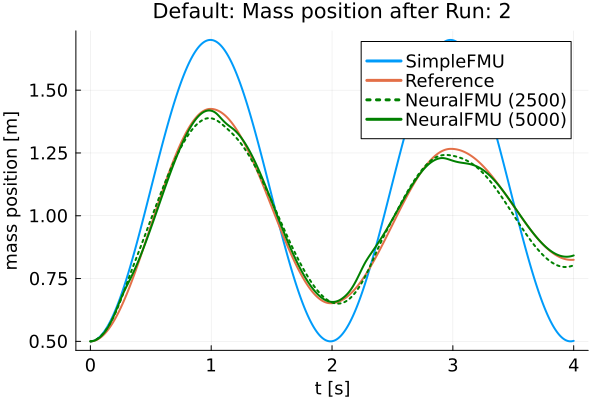

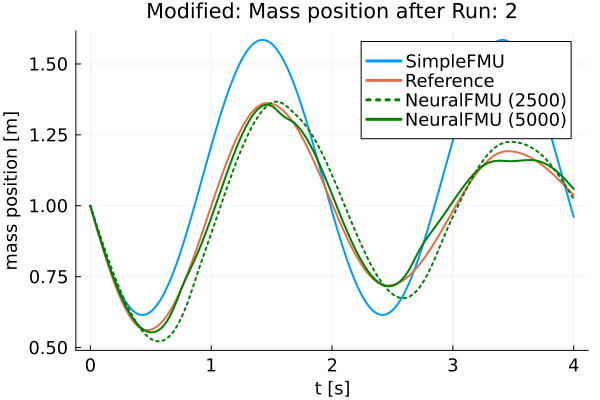

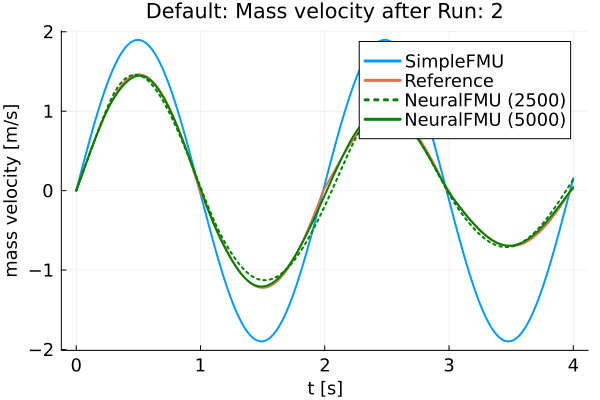

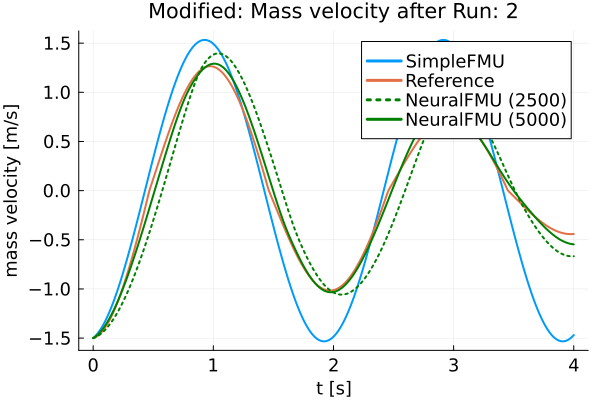

[ Info: Friction model 1 mse: 16.30873694544497
[ Info: Friction model 2 mse: 18.472186845588634


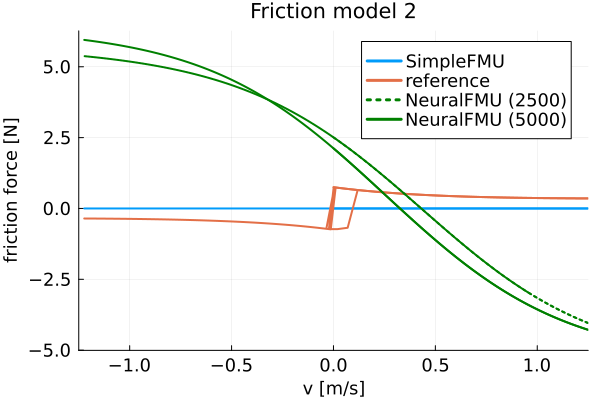

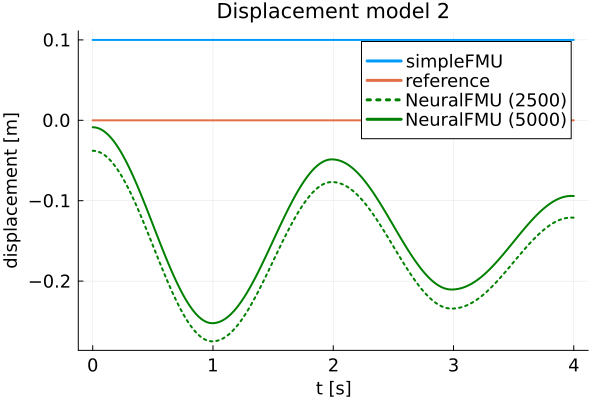

In [24]:
for run in 1:numRuns

    global forces, displacements
    
    optim = Adam(10.0^(-3+1-run)) # going from 1e-3 to 1e-4

    @time for epoch in 1:numEpochs
        @info "Run: $(run)/$(numRuns)  Epoch: $(epoch)/$(numEpochs)"
        FMIFlux.train!(lossSum, neuralFMU, Iterators.repeated((), numIterations), optim; cb=()->callb(paramsNet))
    end
    flush(stderr)
    flush(stdout)
    
    push!(solutionAfter, neuralFMU(x₀))
    push!(solutionAfterMod, neuralFMU(xMod₀))

    # generate all plots for the position and velocity
    plot_all_results(realSimData, realSimDataMod, simpleSimData, simpleSimDataMod, solutionAfter, solutionAfterMod)
    
    # friction model extraction
    layersBottom = neuralFMU.model.layers[3:5]
    netBottom = Chain(layersBottom...)
    transferFlatParams!(netBottom, paramsNet, 7)
    
    plot_friction_model!(realSimData, netBottom, forces) 
    
    # displacement model extraction
    layersTop = neuralFMU.model.layers[1:1]
    netTop = Chain(layersTop...)
    transferFlatParams!(netTop, paramsNet, 1)

    plot_displacement_model!(realSimData, netTop, displacements, tSave, displacement)
end

Finally, the FMUs are cleaned-up.

In [25]:
unloadFMU(simpleFMU)
unloadFMU(realFMU)

### Summary

Based on the plots, it can be seen that the curves of the *realFMU* and the *neuralFMU* are very close. The *neuralFMU* is able to learn the friction and displacement model.

### Source

[1] Tobias Thummerer, Lars Mikelsons and Josef Kircher. 2021. **NeuralFMU: towards structural integration of FMUs into neural networks.** Martin Sjölund, Lena Buffoni, Adrian Pop and Lennart Ochel (Ed.). Proceedings of 14th Modelica Conference 2021, Linköping, Sweden, September 20-24, 2021. Linköping University Electronic Press, Linköping (Linköping Electronic Conference Proceedings ; 181), 297-306. [DOI: 10.3384/ecp21181297](https://doi.org/10.3384/ecp21181297)
